# **Khởi tạo**

**Import thư viện**

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, LSTM, Dense, Flatten, Reshape

**Đọc và xử lý dữ liệu**

In [106]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data = data[['Price']]

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)

    return data

**Xây dựng mô hình**

In [107]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [108]:
# Hàm Create Dataset
def create_dataset(dataset, seq_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        dataX.append(window)
        dataY.append(dataset[i + seq_size, 0])
    return np.array(dataX), np.array(dataY)

In [109]:
def CNN_LSTM_prediction(name, data, train_ratio=0.7, days=30):
    data = data.reset_index()['Price']

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = len(data) - train_size
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    seq_size = 100
    X_train, y_train = create_dataset(train_data, seq_size)
    X_test, y_test = create_dataset(test_data, seq_size)
    
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  
    # Xây dựng mô hình CNN-LSTM
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=50, return_sequences=True, activation='relu'))
    model.add(Dropout(0.2))
    # model.add(LSTM(units=20, return_sequences=True))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # model.add(Dense(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # model.summary()
    
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # Lấy dữ liệu sau timestep
    y_test_adjusted = data[train_size+seq_size:len(y_pred)+train_size+seq_size]

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)

    # Dự báo các ngày tiếp theo
    x_input = test_data[-seq_size:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < days:
        if len(temp_input) > seq_size:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
    
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    
    # Vẽ hình
    plt.title('Linear Regression {} ({})'.format(train_ratio, name))
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+seq_size+1, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))
    prediect_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+days-1, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
    plt.legend(['Train','Test','Predict','Predict'+str(days)+'days'])
    plt.show()

# **BIDV**

In [110]:
data = read_file("../Dataset/BID Historical Data.csv");
name = 'BIDV'

## **30 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing RMSE: 0.17019491063795417
Testing MAE: 0.03004451014888426
Testing MAPE: 19.741098125379043


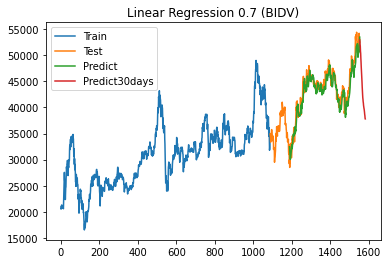

In [111]:
CNN_LSTM_prediction(name, data, 0.7)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 0.14645303905248813
Testing MAE: 0.06953768992144545
Testing MAPE: 14.719846427681007


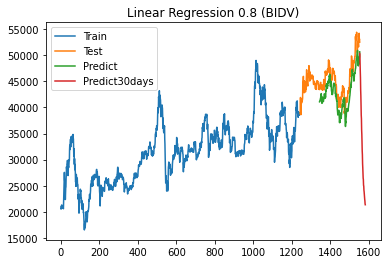

In [112]:
CNN_LSTM_prediction(name, data, 0.8)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing RMSE: 0.10120617069006876
Testing MAE: 0.027684406436031053
Testing MAPE: 9.474584941481346


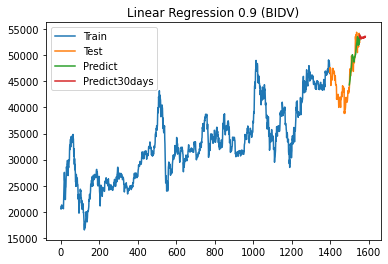

In [113]:
CNN_LSTM_prediction(name, data, 0.9)

## **60 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Testing RMSE: 0.17301637670875553
Testing MAE: 0.04292879860491189
Testing MAPE: 19.721431165725917


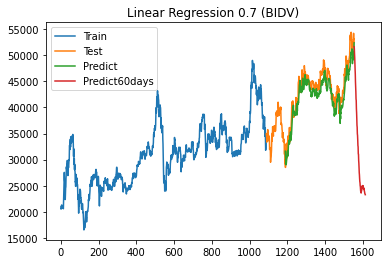

In [114]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 0.1273510857909416
Testing MAE: 0.04028773883755786
Testing MAPE: 12.849699501259447


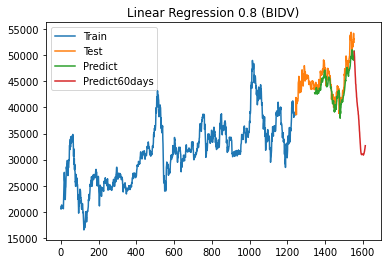

In [115]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 0.10816318532835772
Testing MAE: 0.04655950884073405
Testing MAPE: 9.900313339575142


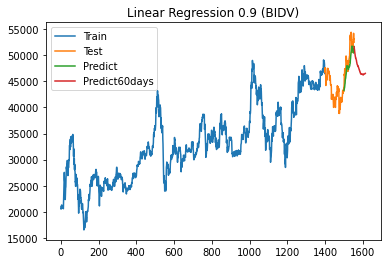

In [116]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing RMSE: 0.172423984385381
Testing MAE: 0.051167097687948686
Testing MAPE: 19.604819391980133


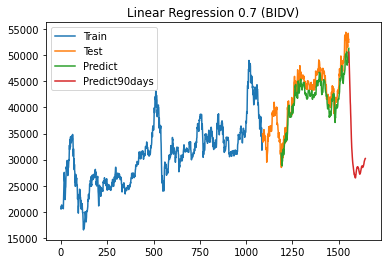

In [117]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing RMSE: 0.12447284756712175
Testing MAE: 0.03159053019056203
Testing MAPE: 12.691677962029447


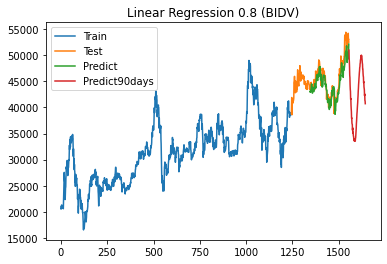

In [118]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Testing RMSE: 0.10577033610651697
Testing MAE: 0.03412799089050454
Testing MAPE: 9.70518961036728


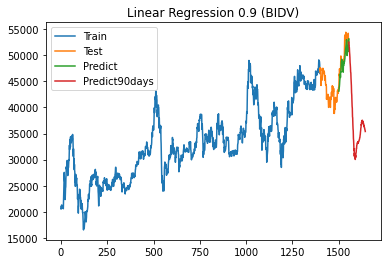

In [119]:
CNN_LSTM_prediction(name, data, 0.9, 90)

# **VCB**

In [120]:
data = read_file("../Dataset/VCB Historical Data.csv");
name = 'VCB'

## **30 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing RMSE: 0.15768960433166518
Testing MAE: 0.0355308464950349
Testing MAPE: 17.251357947827476


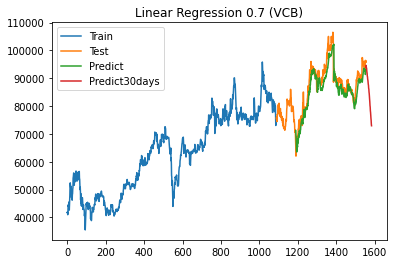

In [121]:
CNN_LSTM_prediction(name, data, 0.7)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing RMSE: 0.11694897547130749
Testing MAE: 0.032499937279568285
Testing MAPE: 11.357541920742825


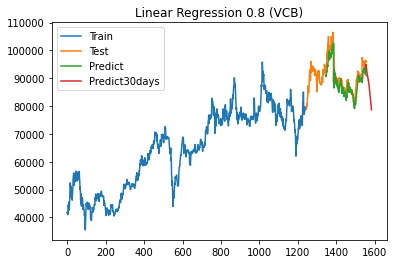

In [122]:
CNN_LSTM_prediction(name, data, 0.8)

**VCB 9:1**

In [123]:
CNN_LSTM_prediction(name, data, 0.9)

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **60 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0435
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0083
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0057
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0054
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0051
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0039
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0042
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0053
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0049
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0042
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0034
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0035
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0027
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0030
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - lo

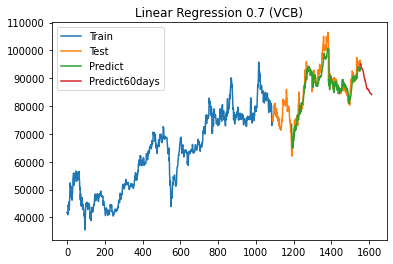

In [ ]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0719
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0090
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0066
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0054
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0053
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0051
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0049
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0054
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0047
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0042
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0040
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0039
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0040
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0041
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - lo

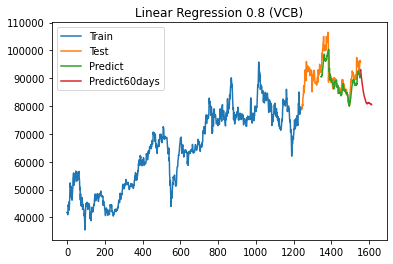

In [ ]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0671
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0086
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0074
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0066
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0057
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0056
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0054
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0046
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0047
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0049
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0040
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0036
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0037
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0032
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - lo

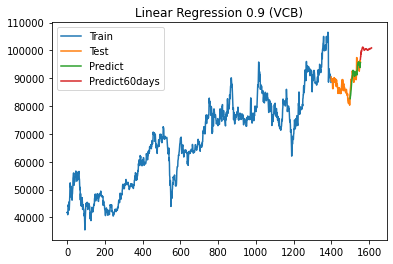

In [ ]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0504
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0086
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0064
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0060
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0048
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0039
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0044
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0045
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0040
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0032
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0033
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0028
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0032
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0029
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - lo

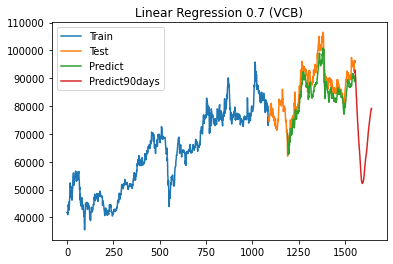

In [ ]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0663
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0077
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0062
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0056
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0052
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0051
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0045
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0042
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0045
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0038
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0035
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0034
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0032
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0035
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - lo

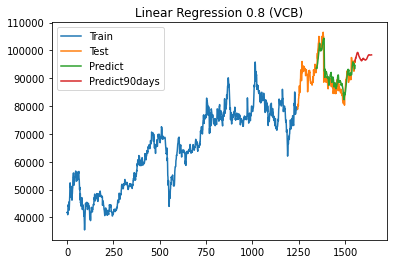

In [ ]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0666
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0089
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0072
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0060
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0055
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0048
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0048
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0039
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0036
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0036
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0033
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0033
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0035
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0031
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - lo

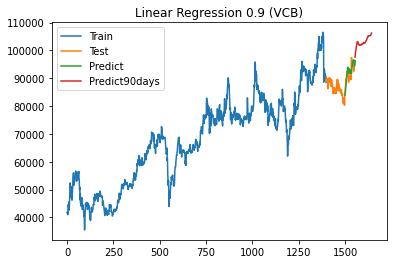

In [ ]:
CNN_LSTM_prediction(name, data, 0.9, 90)

# **MBB**

In [ ]:
data = read_file("../Dataset/MBB Historical Data.csv");
name = 'MBB'

## **30 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0574
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0088
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0087
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0053
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0063
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0044
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0038
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0040
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0037
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0040
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0038
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0033
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0034
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0034
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - lo

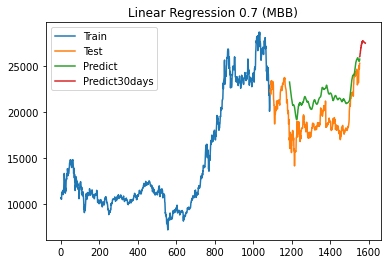

In [ ]:
CNN_LSTM_prediction(name, data, 0.7)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_25 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0772
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0149
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0099
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0089
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0069
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0060
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0055
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0049
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0046
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0048
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0043
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0046
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0055
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0037
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - lo

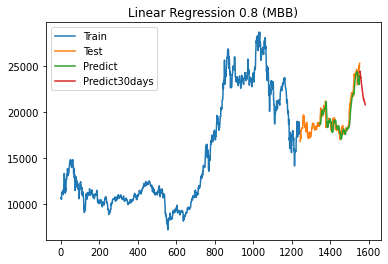

In [ ]:
CNN_LSTM_prediction(name, data, 0.8)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0873
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0135
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0087
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0080
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0066
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0060
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0051
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0055
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0064
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0049
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0049
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0043
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0042
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0042
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - lo

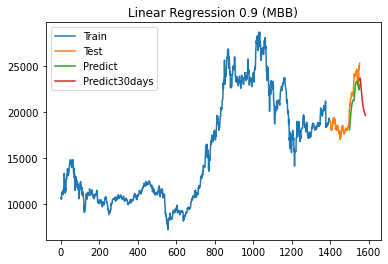

In [ ]:
CNN_LSTM_prediction(name, data, 0.9)

## **60 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0748
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0101
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0086
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0070
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0068
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0052
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0039
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0042
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0038
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0040
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0034
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0035
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0037
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0035
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - lo

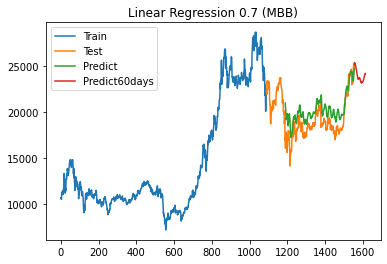

In [ ]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0760
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0138
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0087
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0075
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0058
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0053
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0053
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0049
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0038
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0040
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0041
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0037
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0040
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0034
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - lo

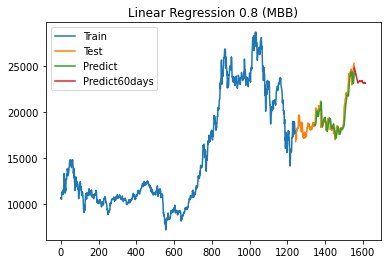

In [ ]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_29 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0719
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0109
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0095
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0070
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0059
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0055
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0055
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0048
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0036
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0042
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0037
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0035
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0036
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0032
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - lo

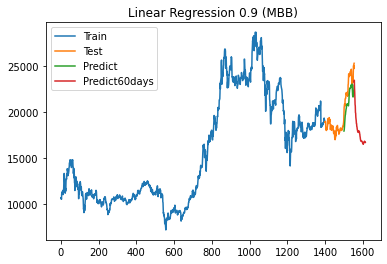

In [ ]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0736
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0105
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0088
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0068
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0053
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0053
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0036
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0041
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0033
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0035
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0031
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0033
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0036
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0037
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - lo

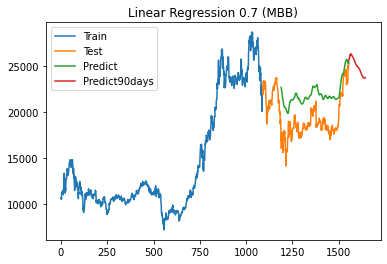

In [ ]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_31 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0661
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0149
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0097
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0076
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0056
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0053
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0053
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0049
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0047
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0046
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0043
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0040
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0040
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0044
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - lo

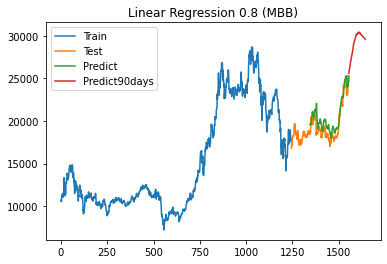

In [ ]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 99, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 49, 50)         │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 49, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 49, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 2450)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │        78,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,857 (476.00 KB)

 Trainable params: 121,857 (476.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0746
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0118
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0087
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0068
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0066
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0051
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0051
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0044
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0036
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0037
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0035
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0034
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0034
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0035
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - lo

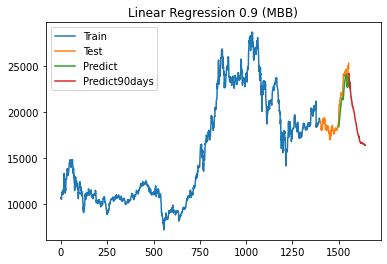

In [ ]:
CNN_LSTM_prediction(name, data, 0.9, 90)